# Projekt LLM 25L - Klasyfkacja tekstu na wybranym zbiorze danych

## Adam Kraś 325177

In [1]:
import torch
import datasets
from collections import Counter
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
!nvidia-smi

Wed May 21 11:10:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.20             Driver Version: 570.133.20     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P3             10W /   55W |       3MiB /   8188MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Wczytanie wybranego zbioru danych
dataset = datasets.load_dataset("community-datasets/yahoo_answers_topics")

In [5]:
dataset["train"][42]  # Wyświetlenie przykładu z zestawu danych

{'id': 42,
 'topic': 6,
 'question_title': 'When will Google buy Yahoo?',
 'question_content': 'The two businesses are very complementary in terms of strengths and weaknesses. Do we want to beat ourselves up competing with each other for resources and market share, or unite to beat MSFT?',
 'best_answer': "Their respective market caps are too close for this to ever happen.\\nInterestingly, many reporters, analysts and tech pundits that I talk to think that the supposed competition between Google and Yahoo is fallacious, and that they are very different companies with very different strategies. Google's true competitor is often seen as being Microsoft, not Yahoo. This would support your claim that they are complementary."}

Computers & Internet: 140000
Sports: 140000
Health: 140000
Business & Finance: 140000
Science & Mathematics: 140000
Entertainment & Music: 140000
Education & Reference: 140000
Family & Relationships: 140000
Politics & Government: 140000
Society & Culture: 140000


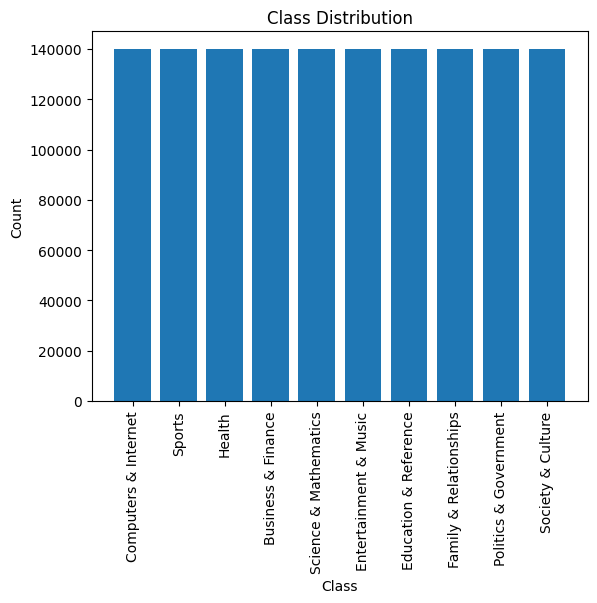

In [6]:
labels = dataset["train"]["topic"]
label_counts = Counter(labels)
label_names = dataset["train"].features["topic"].names

for label_id, count in label_counts.items():
    print(f"{label_names[label_id]}: {count}")

labels_text = [label_names[i] for i in label_counts.keys()]
counts = list(label_counts.values())

plt.bar(labels_text, counts)
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [7]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Porównanie rozmiarów zbiorów danych treningowego i testowego
print(f"Dataset size: {len(train_dataset) + len(test_dataset)}")
print(f"Train dataset size: {len(train_dataset) / (len(train_dataset) + len(test_dataset)) * 100:.2f}%")
print(f"Test dataset size: {len(test_dataset) / (len(train_dataset) + len(test_dataset)) * 100:.2f}%")

Dataset size: 1460000
Train dataset size: 95.89%
Test dataset size: 4.11%


Jak widzimy, stosunek rozmiarów zbioru treningowego i testowego są dalekie od idealnych. Ponadto, nie ma zbioru walidaycjnego. Zróbmy coś z tym.

In [8]:
full_split = train_dataset.train_test_split(test_size=0.2, seed=42)
val_test_split = full_split["test"].train_test_split(test_size=0.5, seed=42)

train_dataset = full_split["train"]
val_dataset = val_test_split["train"]
test_dataset = val_test_split["test"]

# Sprawdzenie rozmiarów zbiorów danych po podziale
print(f"Dataset size: {len(train_dataset) + len(test_dataset) + len(val_dataset)}")
print(f"Train dataset size: {len(train_dataset) / (len(train_dataset) + len(test_dataset) + len(val_dataset)) * 100:.2f}%")
print(f"Test dataset size: {len(test_dataset) / (len(train_dataset) + len(test_dataset) + len(val_dataset)) * 100:.2f}%")
print(f"Validation dataset size: {len(val_dataset) / (len(train_dataset) + len(test_dataset) + len(val_dataset)) * 100:.2f}%")

Dataset size: 1400000
Train dataset size: 80.00%
Test dataset size: 10.00%
Validation dataset size: 10.00%


In [9]:
# Przygotowanie modelu
q_config = BitsAndBytesConfig(load_in_8bit=True)

base_model_id = "microsoft/phi-1_5"

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=q_config,
    torch_dtype=torch.float16,
    trust_remote_code=True,
)

In [10]:
print(model)

print(f"\n\nZajętość pamięci przez model: {model.get_memory_footprint() / 1024**3:0.3f}GB")

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=True)
          (dense): Linear8bitLt(in_features=2048, out_features=2048, bias=True)
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear8bitLt(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear8bitLt(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (rotary_emb): PhiRotaryEmbedding()
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (final_la

In [11]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    use_fast=True,
)
print(f"Rozmiar słownika: {tokenizer.vocab_size}")

Rozmiar słownika: 50257
